In [1]:
from collections import defaultdict
import sys
import gym
import numpy as np

env = gym.make('Blackjack-v0')

In [2]:
print(env.action_space)
print(env.observation_space)

Discrete(2)
Tuple(Discrete(32), Discrete(11), Discrete(2))


In [3]:
for i_episode in range(3):
    state = env.reset()
    while(True):
        print(state)
        action = env.action_space.sample() # Random action
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(7, 10, False)
(9, 10, False)
(18, 10, False)
End game! Reward:  -1
You lost :(

(14, 10, False)
End game! Reward:  -1
You lost :(

(10, 10, False)
End game! Reward:  -1.0
You lost :(



In [4]:
def generate_episode_from_limit_stochastic(env):
    episode = []
    state = env.reset()
    while(True):
        probs = [0.8, 0.2] if state[0]<18 else [0.2, 0.8]
        action = np.random.choice(np.arange(env.action_space.n), p=probs)
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [5]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # Initialize empty dictionaries of arrays.
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # Loop over episodes.
    for i_episode in range(1, num_episodes+1):
        # Monitor progress.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        # To check for first visit of state, action pair in an episode.
        visited = defaultdict(lambda: np.full(shape=env.action_space.n, fill_value = False))
        # Generate an episode.
        episode = generate_episode(env)
        # Get states, actions and rewards from the episode.
        states, actions, rewards = zip(*episode)
        # Prepare for discounting.
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        # Update the sum of the returns, number of visits, and action-value 
        # function estimates for each state-action pair in the episode.
        for i in range(len(states)):
            if visited[states[i]][actions[i]] == False:
                visited[states[i]][actions[i]] = True
                returns_sum[states[i]][actions[i]] += sum(discounts[:-(i+1)]*rewards[i:])
                N[states[i]][actions[i]] += 1
                Q[states[i]][actions[i]] = returns_sum[states[i]][actions[i]]/N[states[i]][actions[i]]
    return Q

In [6]:
from plot_utils import plot_blackjack_values

# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

Episode 500000/500000.

<Figure size 2000x2000 with 2 Axes>

In [7]:
def generate_episode_epsilon_greedy_policy(bj_env, epsilon, Q):
    episode = []
    state = bj_env.reset()
    while True:
        if (Q[state] == Q[state][0]).all():
            probs = [0.5]*env.action_space.n
        else:
            greedy_action_prob = (1-epsilon)+(epsilon/env.action_space.n)
            non_greedy_action_prob = (epsilon/env.action_space.n)
            probs = np.array([greedy_action_prob if i==Q[state].max() else non_greedy_action_prob for i in Q[state]])
        action = np.random.choice(np.arange(env.action_space.n), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [15]:
def mc_control_GLIE(env, num_episodes, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionaries of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    N = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        visited = defaultdict(lambda: np.full(shape=env.action_space.n, fill_value = False))
        epsilon = epsilon = 1.0/((i_episode/8000)+1)
        episode = generate_episode_epsilon_greedy_policy(env, epsilon, Q)
        states, actions, rewards = zip(*episode)
        discounts =np.array([gamma**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            if visited[state][actions[i]] == False:
                visited[state][actions[i]] = True
                N[state][actions[i]] += 1
                temp = sum(discounts[:-(i+1)]*rewards[i:])-Q[state][actions[i]]
                Q[state][actions[i]] += (1/N[state][actions[i]])*temp
        
    policy = {k:np.argmax(v) for k, v in Q.items()}    
    return policy, Q

In [16]:
# obtain the estimated optimal policy and action-value function
policy_glie, Q_glie = mc_control_GLIE(env, 500000)

Episode 500000/500000.

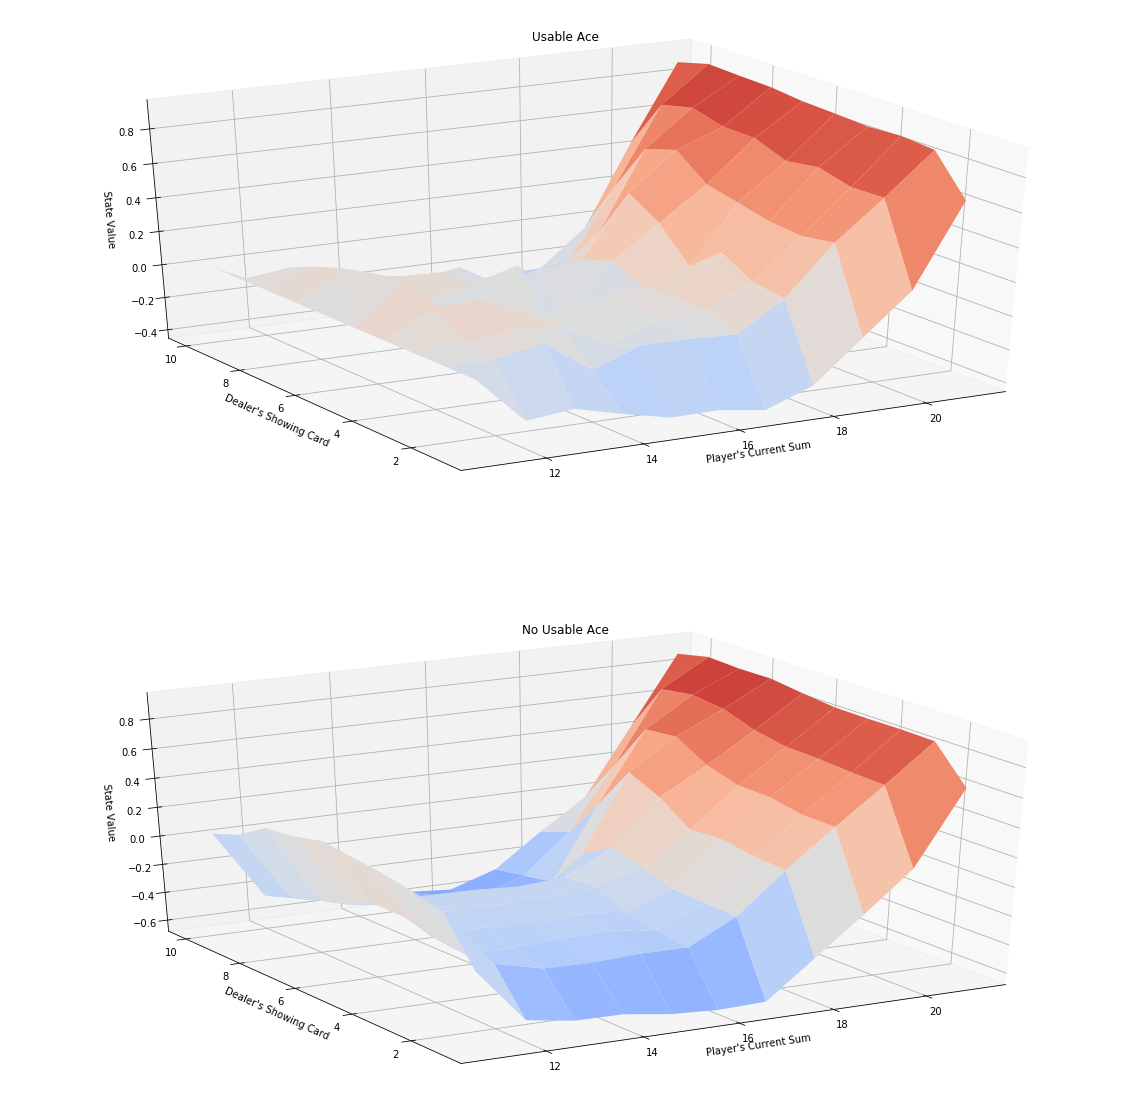

In [17]:
# obtain the state-value function
V_glie = dict((k,np.max(v)) for k, v in Q_glie.items())

# plot the state-value function
plot_blackjack_values(V_glie)

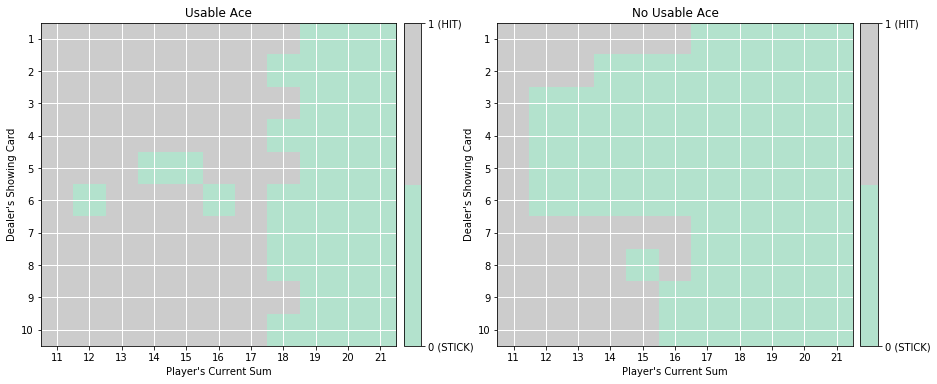

In [18]:
from plot_utils import plot_policy

# plot the policy
plot_policy(policy_glie)

In [30]:
def mc_control_alpha(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        visited = defaultdict(lambda: np.full(shape = env.action_space.n, fill_value = False, dtype = bool))
        epsilon = 1/((i_episode/8000)+1)
        episode = generate_episode_epsilon_greedy_policy(env, epsilon, Q)
        states, actions, rewards = zip(*episode)
        discounts = np.array([gamma**i for i in range(len(states)+1)])
        for i, state in enumerate(states):
            if visited[state][actions[i]] == False:
                visited[state][actions[i]] = True
                Gt = sum(rewards[i:]*discounts[:-(i+1)])
                Q[state][actions[i]] += alpha*(Gt-Q[state][actions[i]])
            
    policy = {k:np.argmax(v) for k, v in Q.items()}
    return policy, Q

In [34]:
# obtain the estimated optimal policy and action-value function
policy_alpha, Q_alpha = mc_control_alpha(env, 1000000, 0.008)

Episode 1000000/1000000.

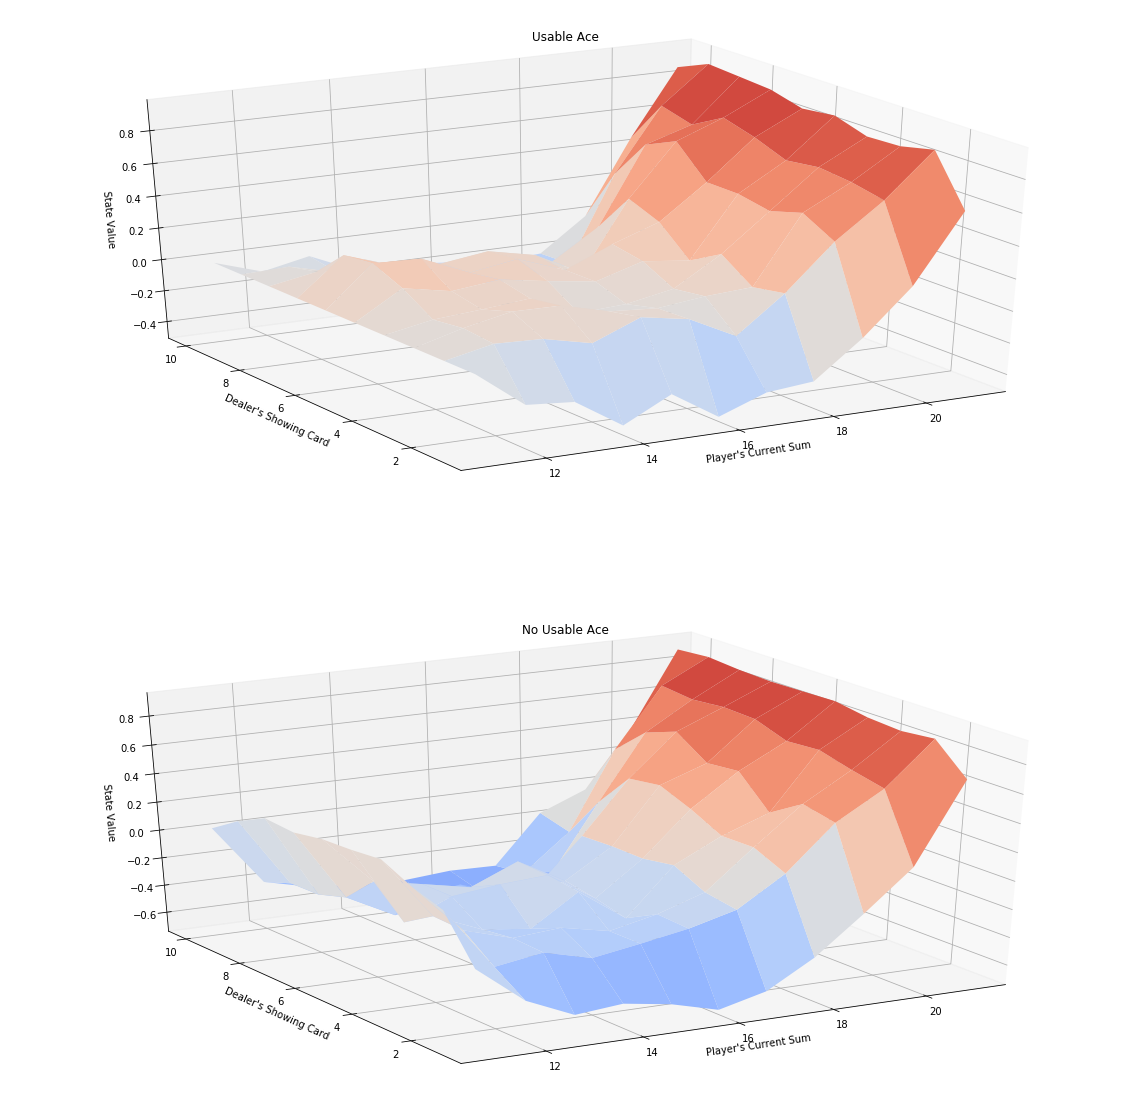

In [35]:
# obtain the state-value function
V_alpha = dict((k,np.max(v)) for k, v in Q_alpha.items())

# plot the state-value function
plot_blackjack_values(V_alpha)

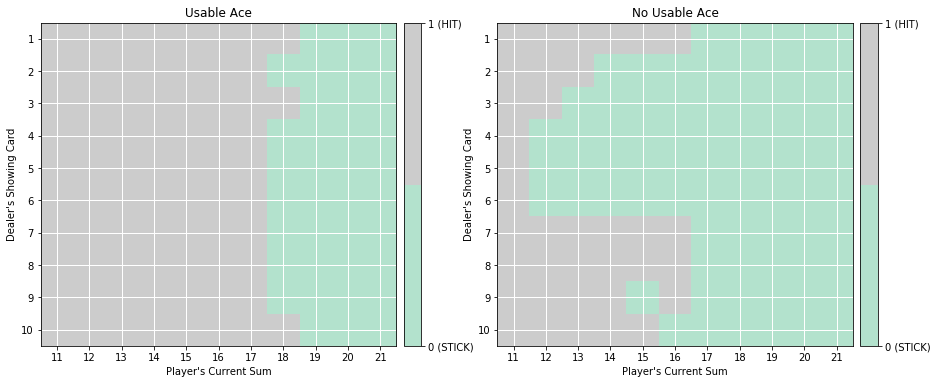

In [37]:
# plot the policy
plot_policy(policy_alpha)